<a href="https://colab.research.google.com/github/gvozdila/kaggle-xray/blob/FastAI/FastAI_xray_f1Score_%D0%BF%D1%81%D0%B8%D1%85%D0%BE%D0%B4%D0%B5%D0%BB%D0%B8%D0%BA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#для kaggle 
#!pip install --user ../input/fastaimaster/torch-1.9.0-cp37-cp37m-manylinux1_x86_64.whl
!pip install -U fastai


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 213 kB 4.9 MB/s 
     |████████████████████████████████| 61 kB 10.6 MB/s 
  Attempting uninstall: fastcore
    Found existing installation: fastcore 1.4.4
    Uninstalling fastcore-1.4.4:
      Successfully uninstalled fastcore-1.4.4
  Attempting uninstall: fastai
    Found existing installation: fastai 2.6.3
    Uninstalling fastai-2.6.3:
      Successfully uninstalled fastai-2.6.3


In [2]:
import fastcore
import fastai
print(f'fastcore version {fastcore.__version__} installed.')
print(f'fastai version {fastai.__version__} installed.')

fastcore version 1.4.5 installed.
fastai version 2.7.3 installed.


In [ ]:
#Когда будем юзать fastai2.medical.imaging , пока не используется
#!pip install pydicom kornia opencv-python scikit-image

In [3]:
import pandas as pd
%matplotlib inline

In [ ]:
#!pip install --no-cache-dir -I pillow
#еще один костыль.Если  ругается,типа AttributeError: module 'PIL.Image' has no attribute 'Resampling',раскомментировать и выполнить один раз

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 3.1 MB 7.5 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [4]:
from fastai import *
from fastai.vision.all import *


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -j /content/drive/MyDrive/train_xray.zip -d /content/drive/MyDrive/train_xray

Archive:  /content/drive/MyDrive/train_xray.zip
  inflating: /content/drive/MyDrive/train_xray/1.2.826.0.1.3680043.8.498.49042731076391847359377797243991936549-c.bone.jpg  
  inflating: /content/drive/MyDrive/train_xray/1.2.826.0.1.3680043.8.498.49042731076391847359377797243991936549-c.jpg  
  inflating: /content/drive/MyDrive/train_xray/1.2.826.0.1.3680043.8.498.21739376742858908135232935836921176201-c.jpg  
  inflating: /content/drive/MyDrive/train_xray/1.2.826.0.1.3680043.8.498.21739376742858908135232935836921176201-c.bone.jpg  
  inflating: /content/drive/MyDrive/train_xray/1.2.826.0.1.3680043.8.498.52369662527230429679937679591560328077-c.bone.jpg  
  inflating: /content/drive/MyDrive/train_xray/1.2.826.0.1.3680043.8.498.52369662527230429679937679591560328077-c.jpg  
  inflating: /content/drive/MyDrive/train_xray/1.2.826.0.1.3680043.8.498.45545811527291099594261899260114531910-c.jpg  
  inflating: /content/drive/MyDrive/train_xray/1.2.826.0.1.3680043.8.498.455458115272910995942618

In [6]:
item_tfms = [Resize(224)]
batch_tfms = Normalize.from_stats(*imagenet_stats) 

In [7]:
train_path='/content/drive/MyDrive/train_xray'
train_df = pd.read_csv('/content/drive/MyDrive/train.csv')[['SOPInstanceUID', 'Target']]
train_df['Target'] = train_df['Target'].apply(lambda x: x.strip())





In [8]:
train_df

,SOPInstanceUID,Target
0,1.2.826.0.1.3680043.8.498.10025629581362719970278200333618114258,0
1,1.2.826.0.1.3680043.8.498.10036150326276641158002573300029848125,15
2,1.2.826.0.1.3680043.8.498.10038426859954986240523417641213777162,12
3,1.2.826.0.1.3680043.8.498.10050991192143676483577217922037244257,14
4,1.2.826.0.1.3680043.8.498.10053309524595490852815579052225336016,3
...,...,...
1733,1.2.826.0.1.3680043.8.498.99711016467406172920578985719244800351,14
1734,1.2.826.0.1.3680043.8.498.99727280485333900933067489723088200708,11
1735,1.2.826.0.1.3680043.8.498.99935008698914755885142961280499046059,3
1736,1.2.826.0.1.3680043.8.498.99969671777553755311455387279891445345,2


In [9]:
dls = ImageDataLoaders.from_df(train_df,
                               path=train_path, 
                               suff='-c.jpg',
                               item_tfms=item_tfms,
                               batch_tfms=batch_tfms, 
                               shuffle=True, 
                               bs=64, 
                               valid_pct=0.2,
                               label_delim=' ',# !важно! - предупреждаем нейросеть,что у нас есть некоторая multi-label problem
                                               # без этого будет вываливаться ошибка при обучении cnn
                               num_workers = 0,#Чтобы не переполнялась память при обучении
                               )

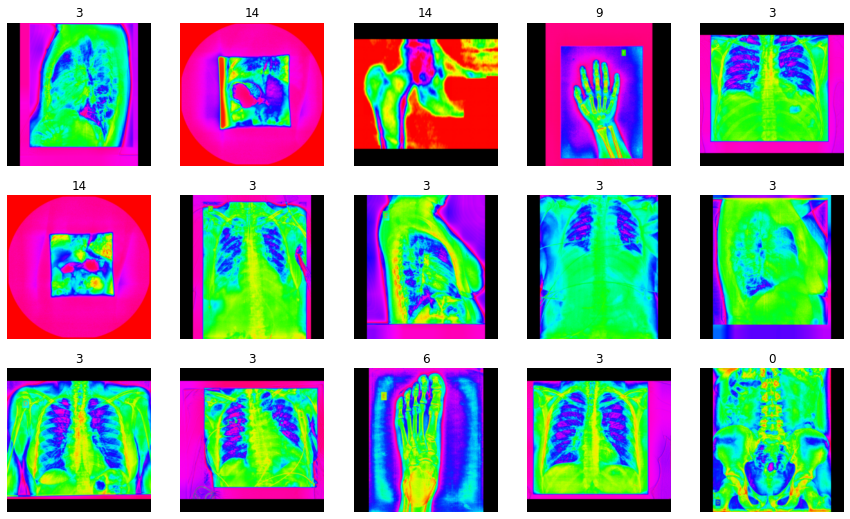

In [10]:
dls.train.show_batch(max_n=15)


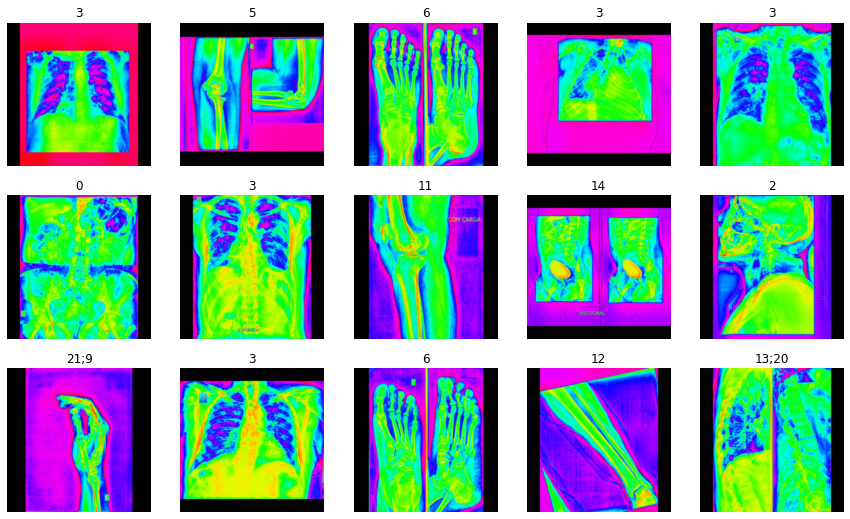

In [11]:
dls.valid.show_batch(max_n=15)

In [12]:
#Чтобы корректно считалась метрика F1Score, взял с public kernel этого Kaggle-соревнования.
f1_macro = F1ScoreMulti(thresh=0.5, average='macro')
f1_samples = F1ScoreMulti(thresh=0.5, average='samples')
f1_micro = F1ScoreMulti(thresh=0.5, average='micro')
f1_weighted = F1ScoreMulti(thresh=0.5, average='weighted')



In [13]:
learn = vision_learner(dls, resnet50, 
                    metrics=[partial(accuracy_multi, thresh=0.5), f1_macro, f1_samples, f1_micro, f1_weighted]
                      )

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

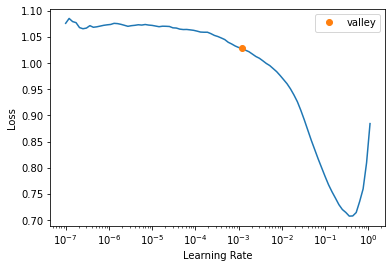

In [14]:
lr = learn.lr_find() 

In [15]:
learn.fine_tune(60, lr[0])

epoch,train_loss,valid_loss,accuracy_multi,f1_score,f1_score,f1_score,f1_score,time
0,0.979178,0.715594,0.592088,0.157509,0.191126,0.182677,0.431033,01:48


epoch,train_loss,valid_loss,accuracy_multi,f1_score,f1_score,f1_score,f1_score,time
0,0.859786,0.676805,0.605187,0.162424,0.192572,0.184524,0.453402,00:35
1,0.835052,0.651226,0.628242,0.170104,0.204075,0.193750,0.464648,00:35
2,0.820304,0.640919,0.636626,0.174716,0.210232,0.198729,0.473053,00:35
3,0.797945,0.624484,0.654310,0.184644,0.222419,0.210589,0.487327,00:36
4,0.778920,0.603886,0.684176,0.198850,0.246182,0.228480,0.506359,00:36
5,0.758835,0.587526,0.703563,0.210561,0.260382,0.240349,0.521347,00:35
6,0.733476,0.557001,0.735787,0.223754,0.293060,0.260359,0.530807,00:35
7,0.705331,0.528457,0.771286,0.246447,0.328619,0.289666,0.550506,00:35
8,0.672844,0.484699,0.830102,0.284007,0.421744,0.352471,0.578024,00:35
9,0.633890,0.440515,0.873985,0.324906,0.491826,0.417676,0.613081,00:35


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


,target,predicted,probabilities,loss
0,3,2,"TensorBase([4.1092e-04, 4.0036e-04, 4.1783e-04, 1.5263e-04, 3.0314e-04, 5.3769e-03,\n 3.2905e-04, 2.2892e-04, 3.2944e-03, 6.2225e-04, 1.4030e-04, 3.3743e-04,\n 9.9936e-01, 7.9099e-03, 2.9092e-04, 3.7211e-05, 7.6757e-04, 2.5171e-04,\n 2.0083e-04, 1.5952e-04, 3.0740e-04, 9.1869e-04])",0.7988071441650391
1,2;20,13;20,"TensorBase([1.0110e-03, 5.5335e-04, 1.1991e-04, 2.2156e-04, 6.4902e-04, 9.9305e-01,\n 8.2733e-04, 1.1612e-04, 1.2800e-03, 2.7580e-04, 2.9042e-04, 2.3110e-04,\n 1.1167e-04, 9.9805e-01, 1.0484e-04, 3.7056e-04, 1.7644e-04, 1.9736e-04,\n 2.5647e-04, 3.6371e-04, 2.5678e-04, 1.1109e-04])",0.6399039626121521
2,13;20,,"TensorBase([4.8705e-01, 9.2673e-04, 1.4803e-03, 2.5666e-04, 1.4354e-03, 9.2833e-04,\n 3.6202e-03, 1.5255e-04, 2.7389e-04, 1.2263e-03, 6.9304e-04, 8.0905e-04,\n 3.1678e-04, 3.4342e-03, 2.1814e-04, 1.9208e-01, 6.8718e-04, 8.2013e-04,\n 8.7780e-04, 4.7338e-04, 5.8381e-04, 3.7551e-04])",0.6160097122192383
3,9,21;9,"TensorBase([3.1163e-05, 1.8168e-05, 4.8752e-05, 3.2286e-05, 3.8410e-05, 1.8328e-05,\n 3.6087e-05, 1.9650e-05, 1.0747e-05, 3.1909e-05, 1.9854e-05, 3.0581e-05,\n 1.6497e-05, 4.5940e-05, 1.0000e+00, 1.1783e-06, 2.0544e-05, 5.8750e-06,\n 1.5594e-06, 7.2716e-06, 1.2944e-05, 1.0000e+00])",0.5965762734413147
4,1;11;12,,"TensorBase([4.5830e-04, 2.3784e-01, 1.6918e-03, 1.7387e-03, 5.1663e-02, 5.5496e-04,\n 1.1497e-03, 3.1498e-04, 7.5248e-04, 6.4645e-04, 1.0229e-03, 1.5476e-02,\n 1.7684e-03, 5.4770e-04, 8.9088e-04, 2.2031e-04, 5.7285e-04, 1.8213e-03,\n 2.5275e-04, 5.8313e-04, 9.9730e-03, 3.8073e-04])",0.49059197306632996
5,14,13;20,"TensorBase([4.8082e-04, 1.3169e-04, 5.1495e-04, 7.5683e-05, 4.0020e-04, 5.5719e-01,\n 7.0747e-04, 9.5754e-04, 3.8717e-04, 7.4433e-04, 1.6671e-04, 3.2752e-04,\n 1.0447e-02, 8.6340e-01, 2.1112e-03, 1.1484e-05, 1.0770e-03, 6.7437e-04,\n 1.9762e-04, 2.2434e-04, 7.3820e-04, 9.0935e-04])",0.45817098021507263
6,8,12,"TensorBase([8.5216e-05, 5.7650e-04, 3.6495e-04, 1.3135e-04, 9.8401e-01, 1.2899e-04,\n 1.5652e-04, 2.3777e-04, 1.3041e-03, 2.2048e-04, 2.7638e-04, 6.9229e-04,\n 2.0593e-04, 1.0178e-04, 2.3717e-03, 3.1593e-05, 1.7871e-04, 7.1566e-04,\n 4.4556e-04, 2.9927e-04, 3.7862e-03, 1.4208e-04])",0.44186538457870483
7,5,12,"TensorBase([2.9121e-04, 1.5457e-03, 1.6428e-04, 1.7476e-04, 8.7269e-01, 1.8111e-04,\n 8.3125e-05, 9.5735e-04, 3.4948e-04, 3.3149e-04, 4.1232e-04, 9.0334e-04,\n 5.6100e-04, 3.3698e-04, 1.7209e-03, 1.1718e-05, 3.6239e-04, 8.0621e-04,\n 5.0863e-02, 4.3776e-04, 1.1275e-02, 5.0523e-04])",0.4207797646522522
8,14,,"TensorBase([4.6614e-04, 9.6294e-05, 1.6735e-04, 7.8812e-05, 1.2019e-04, 3.7303e-04,\n 2.3218e-04, 9.8459e-05, 1.8047e-03, 1.4842e-04, 1.5718e-04, 6.5494e-05,\n 2.9570e-01, 1.5715e-03, 3.0364e-04, 1.1772e-03, 2.6416e-04, 8.1449e-05,\n 1.7577e-04, 6.7571e-05, 1.1963e-04, 2.8185e-04])",0.3966452181339264
9,9,,"TensorBase([0.0997, 0.0007, 0.0025, 0.0011, 0.0007, 0.0407, 0.0015, 0.0034, 0.0012,\n 0.0008, 0.0005, 0.0065, 0.0003, 0.0004, 0.0009, 0.0008, 0.0011, 0.0007,\n 0.0017, 0.0007, 0.0004, 0.0005])",0.34923192858695984


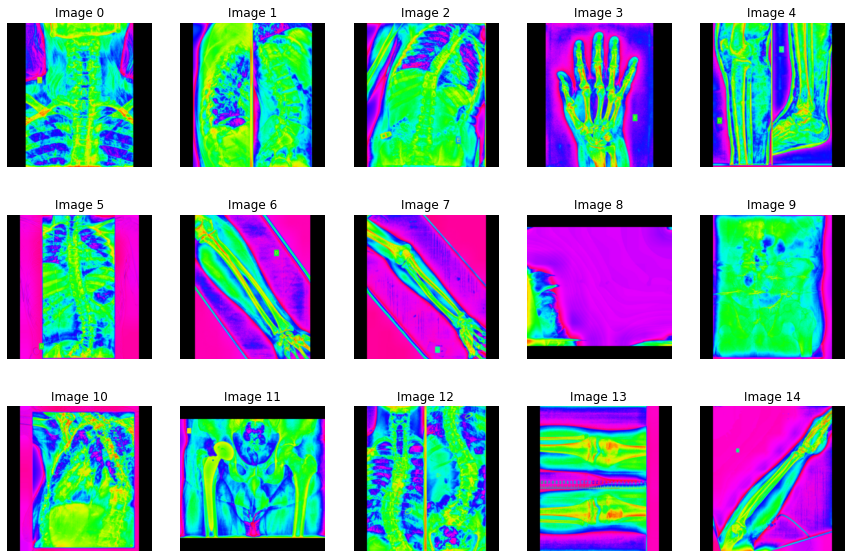

In [18]:
#посмотрим топ-ошибок.Вернее не посмотрим, потому что -вероятно из за деления на ноль при подсчете F1score - некоторые классы не предсказывает.
#Надо пробовать делать valid_pct=0 и указывать для валидации данные из другой папки, которая "тест".
#А все содержимое папки трейн загонять на обучение полностью.Или делать больше данных через аугментацию.
#либо, как тут написано, задавать  параметр zero_division  в sklearn.metrics.classification_report
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(15, figsize=(15, 10))

In [ ]:
#learn.predict("../input/1.2.826.0.1.3680043.8.498.10000428974990117276582711948006105617.jpg")

In [ ]:
learn.export()
learn.save('psycho_model') 

Path('/content/drive/MyDrive/train_xray/models/psycho_model.pth')